**Import Modules**

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
import os
%matplotlib inline
np.random.seed(1)
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

**Helper Functions**

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    # Shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

**Load Dataset**

In [5]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


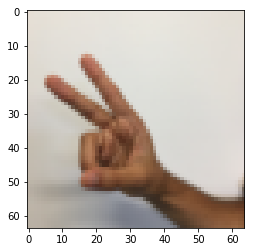

In [6]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

**Normalize and convert to one hot**

In [7]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print(X_train.shape)

(1080, 64, 64, 3)


In [8]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32,shape=(None,n_H0, n_W0, n_C0),name='X')
    Y = tf.placeholder(tf.float32,shape=(None,n_y),name='Y')
    
    return X, Y

In [9]:
def initialize_parameters():
    W1 = tf.get_variable("W1", [4,4,3,8], initializer = tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2,2,8,16], initializer = tf.contrib.layers.xavier_initializer())
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    return Z3

In [11]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [12]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 295, minibatch_size = 64, print_cost = True):

    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y = create_placeholders(n_W0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            accList = []
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost, acc = sess.run([optimizer, cost, accuracy], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                
                accList.append(acc)
                minibatch_cost += temp_cost / num_minibatches
               
            ac=sum(accList)/len(accList)

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost) + " accuracy : %f " %(acc*100))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.933534 accuracy : 14.285715 
Cost after epoch 5: 1.864841 accuracy : 39.285713 
Cost after epoch 10: 1.758837 accuracy : 46.428570 
Cost after epoch 15: 1.496084 accuracy : 57.142860 
Cost after epoch 20: 1.200015 accuracy : 62.500000 
Cost after epoch 25: 0.970967 accuracy : 71.428573 
Cost after epoch 30: 0.847704 accuracy : 73.214287 
Cost after epoch 35: 0.772430 accuracy : 82.142860 
Cost after epoch 40: 0.718483 accuracy : 73.214287 
Cost after epoch 45: 0.654471 accuracy : 89.285713 
Cost after epoch 50: 0.618892 accuracy : 85.714287 
Cost after epoch 55: 0.574980 accuracy : 83.928573 
Cost after epoch 60: 0.547896 accuracy : 85.714287 
Cost after epoch 65: 0.529029 accuracy : 85.714287 
Cost after epoch 70: 0.500378 accuracy : 89.285713 
Cost after epoch 75: 0.479972 a

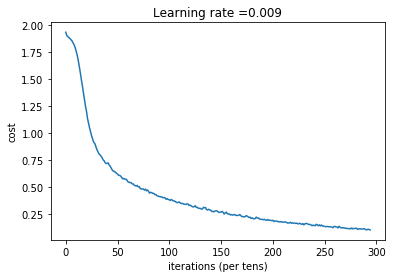

Train Accuracy: 0.98425925
Test Accuracy: 0.89166665


In [13]:
parameters = model(X_train, Y_train, X_test, Y_test)